# Training a Convolutional Neural Network (CNN) with the BSDS500 Dataset for Edge Detection

This code reproduces a practical example of using CNNs for image-to-image transformation, specifically edge detection, based on [[1](#ref1)], [[2](#ref2)], and [[3](#ref3)]. This uses the Berkeley BSDS500 segmentation dataset [[1](#ref1)], which focuses on image segmentation and boundary detection, along with the U-Net architecture.

### References:

[<a name="ref1">1</a>]. P. Arbeláez, M. Maire, C. Fowlkes, and J. Malik, “Contour Detection and Hierarchical Image Segmentation,” *IEEE Transactions on Pattern Analysis and Machine Intelligence*, vol. 33, no. 5, pp. 898–916, May 2011, doi: 10.1109/TPAMI.2010.161.

[<a name="ref2">2</a>]. N. Usuyama and K. Chahal, "UNet/FCN PyTorch," GitHub Repository, 2018. Available online: [https://github.com/usuyama/pytorch-unet](https://github.com/usuyama/pytorch-unet).

[<a name="ref3">3</a>]. I. Ocak and O. Tepencelik, "Edge Detection Using U-Net Architecture," GitHub Repository, 2020. Available online: [https://github.com/iocak28/UNet_edge_detection](https://github.com/iocak28/UNet_edge_detection).


In [1]:
%matplotlib inline

## 1. Import libraries

In [2]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime

import sys
import os
import importlib

In [3]:
sys.path.append('../../src')

from model import Org_UNet

from preprocessing import bsds500
from training import train
from plotting import plot_images, plot_metrics

## 2. Define directories

In [4]:
data_dir = os.path.abspath(os.path.join('..', '..', 'data'))
output_dir = os.path.abspath(os.path.join('..', '..', 'output'))
models_dir = os.path.abspath(os.path.join('..', '..', 'models'))

## 3. Define the device

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 4. Data

### 4.1. Dataset folders

In [6]:
xfolder = data_dir + '/training/BSDS500/images/'
yfolder = data_dir + '/training/BSDS500/ground_truth/'

### 4.2. Image preprocessing

In [7]:
image_transform = bsds500.image_transformation
label_transform = bsds500.label_transformation

### 4.3. Datasets

In [8]:
# n_rotations = 4
# rotations = [i * (360 / n_rotations) for i in range(n_rotations)]  # [0, 90, 180, 270]
rotations = [0, 45, 90, 315]
# rotations = [0]

train_set = bsds500.BSDS500Dataset(
    xfolder + 'train/', 
    yfolder + 'train/', 
    image_transform(), 
    label_transform(), 
    rotations=rotations, 
    input_channels=1
    )
val_set = bsds500.BSDS500Dataset(
    xfolder + 'val/', 
    yfolder + 'val/', 
    image_transform(), 
    label_transform(), 
    rotations=rotations, 
    input_channels=1
)
test_set = bsds500.BSDS500Dataset(
    xfolder + 'test/', 
    yfolder + 'test/', 
    image_transform(noise=False), 
    label_transform(noise=False), 
    rotations=[0], 
    input_channels=1
)

### 4.4. Dataloaders

In [9]:
batch_size = 4
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [10]:
image_datasets = {'train': train_set, 'val': val_set}
dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets.keys()}
dataset_sizes

{'train': 800, 'val': 400}

### 4.5. Plot data

In [11]:
inputs, labels = next(iter(dataloaders['train']))
print(inputs.shape, labels.shape)

torch.Size([4, 1, 320, 480]) torch.Size([4, 1, 320, 480])


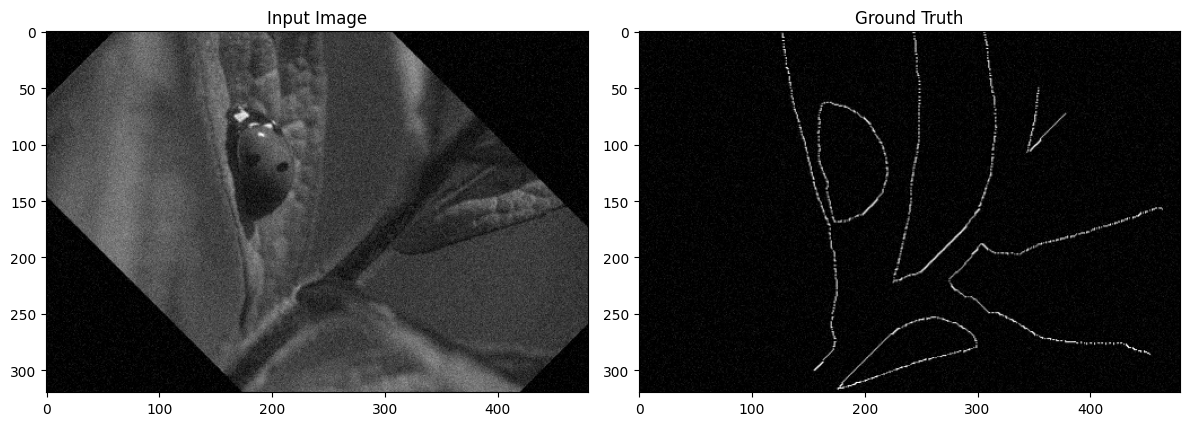

In [12]:
this_image = 0
plot_images.plot_input_gt(inputs[this_image], labels[this_image])

## 5. Model
### 5.1. Define the model

In [13]:
new_model = False  # Set to True to train a new model from scratch

if new_model:
    num_class = 1
    in_ch = 1
    model = Org_UNet.UNet(n_classes=num_class, input_channels=in_ch).to(device)
    model.apply(Org_UNet.initialize_weights);
else:
    save_name = "edge_detection_model_20251015_1ch.pth"
    ckpt_path = os.path.join(models_dir, save_name)

    print(f"Loading model from: {os.path.relpath(ckpt_path)}")
    ckpt = torch.load(ckpt_path, weights_only=False, map_location=device)

    if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
        print("📦 The checkpoint was detected.")
        
        # Default values (in case they are not in the checkpoint)
        hparams = ckpt.get("hparams", {})
        num_class = hparams.get("num_class", 1)
        in_ch = hparams.get("input_channels", 1)
        lr = hparams.get("lr", 1e-4)
        step_size = hparams.get("step_size", 10)
        gamma = hparams.get("gamma", 0.1)
        weight_decay = hparams.get("weight_decay", 0)

        # Create model and load state dict
        model = Org_UNet.UNet(n_classes=num_class, input_channels=in_ch).to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        print("🧠 Model weights loaded successfully.")

        # Create optimizer/scheduler if continuing training
        optimizer_ft = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

        if "optimizer_state_dict" in ckpt:
            optimizer_ft.load_state_dict(ckpt["optimizer_state_dict"])
        if "scheduler_state_dict" in ckpt:
            exp_lr_scheduler.load_state_dict(ckpt["scheduler_state_dict"])

        train_losses = ckpt.get('train_losses', [])
        val_losses = ckpt.get('val_losses', [])
        best_loss = ckpt.get('best_loss', None)
        epoch = ckpt.get("epoch", 0)

        print(f"✅ Checkpoint restored. Last epoch: {epoch}")

    else:
        print("🧩 Complete model detected, loading directly...")
        model = ckpt
        print("✅ Model loaded successfully.")

Loading model from: ..\..\models\edge_detection_model_20251015_1ch.pth
🧩 Complete model detected, loading directly...
✅ Model loaded successfully.


### 5.2. Train the model

In [ ]:
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model, train_losses, val_losses, best_loss = train.train_model(model, optimizer_ft, exp_lr_scheduler, dataloaders, num_epochs=1, device=device)

In [ ]:
plot_metrics.plot_losses(train_losses, val_losses)

### 5.3. Save the model

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # with format: YYYYMMDD_HHMM
model_base_name = 'edge_detection_model'
save_name = f'{model_base_name}_{timestamp}.pth'

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer_ft.state_dict(),
    'scheduler_state_dict': exp_lr_scheduler.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_loss': best_loss,
    'epoch': len(train_losses),
    'hparams': {
        'optimizer': optimizer_ft.__class__.__name__,
        'lr': optimizer_ft.param_groups[0]["lr"],
        'weight_decay': optimizer_ft.param_groups[0].get("weight_decay", 0.0),
        'scheduler': exp_lr_scheduler.__class__.__name__,
        'step_size': getattr(exp_lr_scheduler, "step_size", None),
        'gamma': getattr(exp_lr_scheduler, "gamma", None),
        'num_class': num_class,
        'input_channels': in_ch,
    },
    'rotations': rotations,
}

torch.save(checkpoint, os.path.join(models_dir, save_name))
print(f'Checkpoint saved to {os.path.relpath(os.path.join(models_dir, save_name))}')

## 6. Prediction

In [14]:
model.eval();

### 6.1. Labeled datasets

In [15]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=0)

torch.Size([1, 1, 320, 480])

(1, 320, 480)

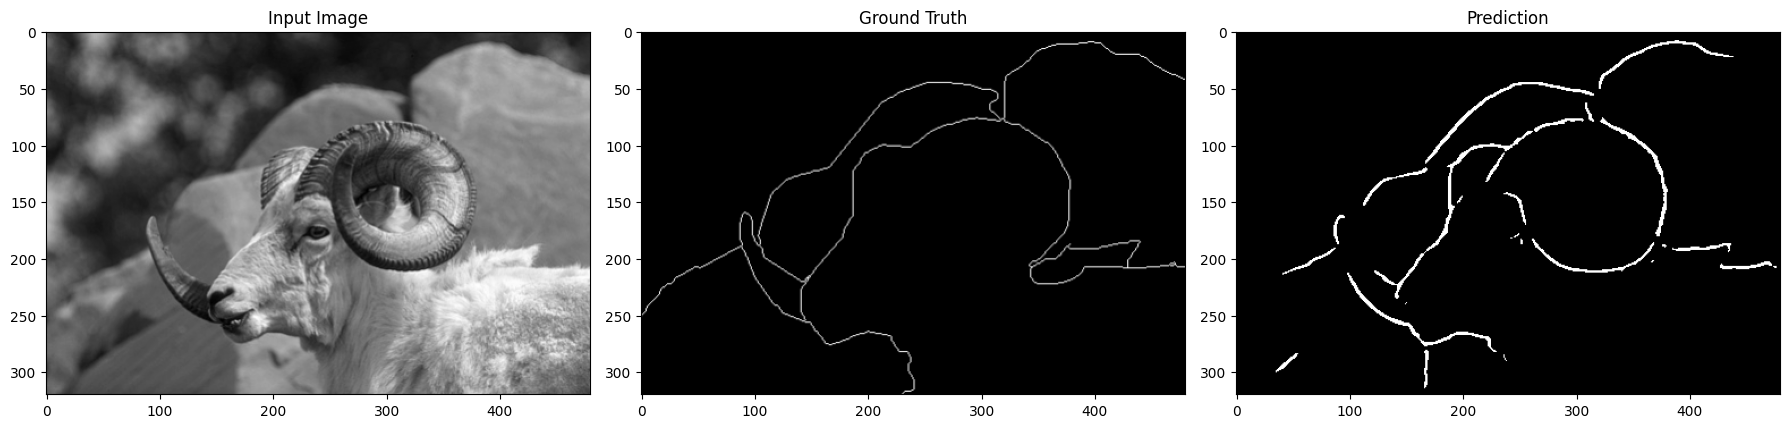

In [27]:
# inputs, labels = next(iter(dataloaders['val']))
inputs, labels = next(iter(test_loader))
pred = model(inputs.to(device))
display(pred.shape)

pred_c = torch.sigmoid(pred).data.cpu().numpy().squeeze(1)
# pred_c = pred.data.cpu().numpy().squeeze(1)
pred_c = np.where(pred_c>=0.5, 1, 0)
display(pred_c.shape);

# %matplotlib ipympl
plot_images.plot_input_gt_pred(inputs[0], labels[0], pred_c[0])

### 6.2. Unlabeled datasets

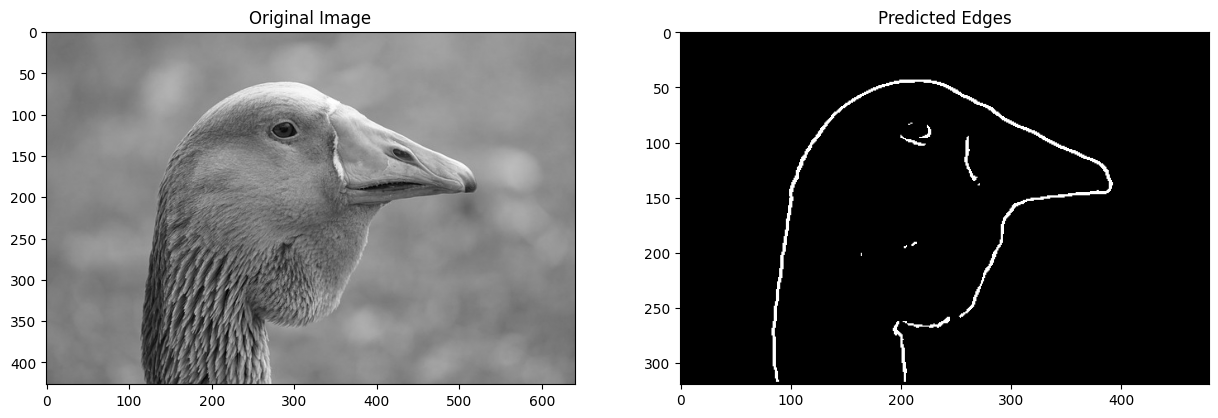

In [28]:
image = Image.open(output_dir + '/test' + '/img_1.jpg')
# image = image.convert("RGB")
image = image.convert("L")

image_transformed = image_transform(noise=False)(image).unsqueeze(0)
pred = model(image_transformed.to(device))
pred_c = torch.sigmoid(pred).data.cpu().numpy()
pred_c = np.where(pred_c>=0.5, 1, 0)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 10))
ax0.imshow(image, cmap='gray')
ax0.set_title('Original Image')
ax1.imshow(pred_c[0, 0], cmap='gray')
ax1.set_title('Predicted Edges')
plt.show()